In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import string
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.stats.mstats import mquantiles
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Import & Explore DF on Exam Day

In [42]:
df = pd.read_csv('https://raw.githubusercontent.com/EthanRosehart/PM_Assignments/refs/heads/main/data_set_hackathon.csv')

# 1. How many Distinct Orders Are Received Each Month

In [43]:
# Convert the "order_date" column to datetime
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')

# Create separate columns for Year and Month
df['Year'] = df['order_date'].dt.year
df['Month'] = df['order_date'].dt.month

# Now group by Year and Month and count distinct Customer Order Codes
monthly_order_counts = (
    df.groupby(['Year', 'Month'])['Customer Order Code']
    .nunique()
    .reset_index(name='Distinct Order Count')
)

# Create a nicely formatted Year-Month column
monthly_order_counts['Year-Month'] = monthly_order_counts.apply(
    lambda row: f"{row['Year']}-{row['Month']:02d}", axis=1
)

print(monthly_order_counts)

    Year  Month  Distinct Order Count Year-Month
0   2009      7                    38    2009-07
1   2009      8                     9    2009-08
2   2009      9                    12    2009-09
3   2009     10                     4    2009-10
4   2009     11                     2    2009-11
5   2009     12                    21    2009-12
6   2010      1                    29    2010-01
7   2010      2                    36    2010-02
8   2010      3                    43    2010-03
9   2010      4                    11    2010-04
10  2010      5                     1    2010-05
11  2010      6                     1    2010-06
12  2010     12                    34    2010-12
13  2011      1                   124    2011-01
14  2011      2                    53    2011-02
15  2011      3                    29    2011-03
16  2011      4                     6    2011-04
17  2011      5                     4    2011-05
18  2011      6                     6    2011-06
19  2011      7     

In [44]:
# Dropping rows where 'value' is NULL
df = df.dropna(subset=['value'])

# Filtering out rows where Year is 2012
df = df[df['Year'] != 2012]

# Convert non-numeric values in the 'items' column to 0
df['items'] = pd.to_numeric(df['items'], errors='coerce').fillna(0).astype(int)

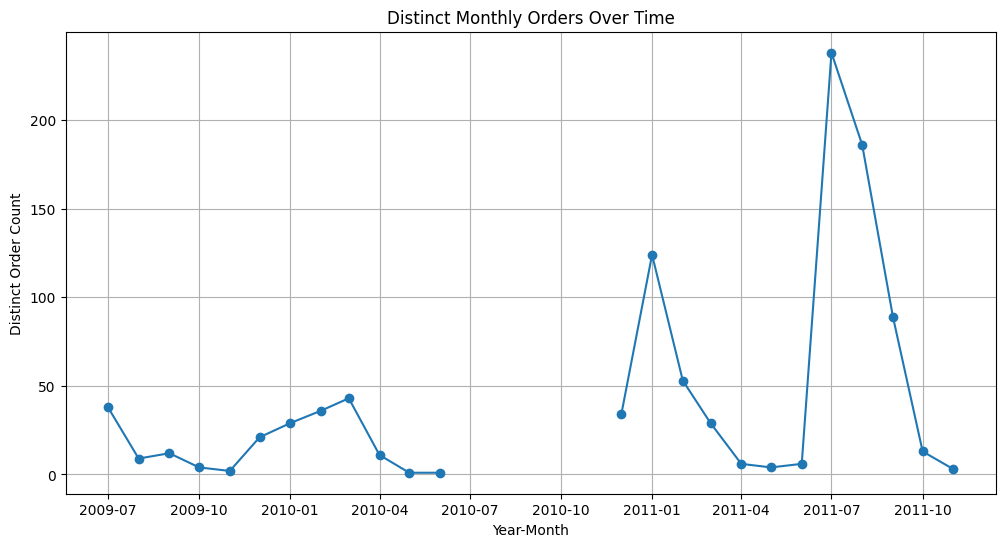

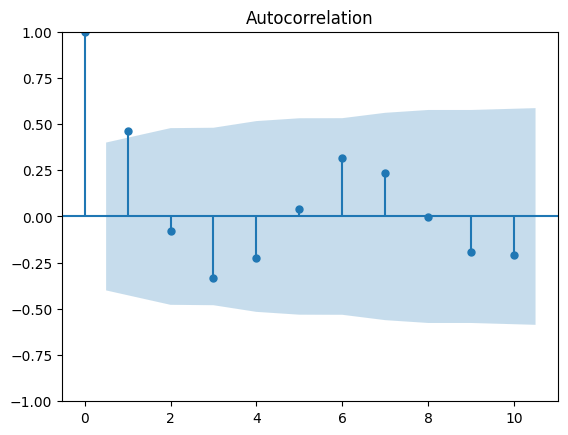

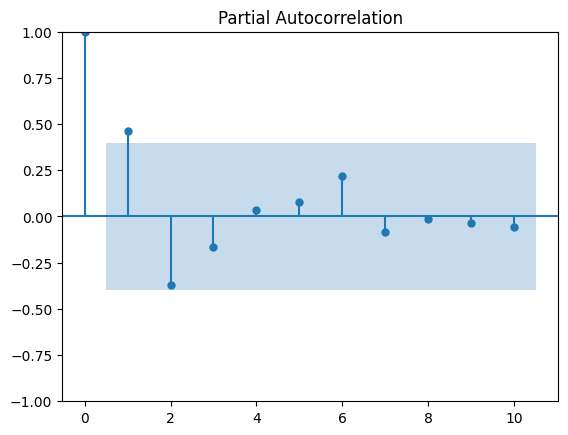

Best SARIMA order: (2, 1, 0) Seasonal order: (2, 1, 0, 6) with AIC: -15.164047787596722
                                     SARIMAX Results                                     
Dep. Variable:              Distinct Order Count   No. Observations:                   24
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 6)   Log Likelihood                  12.582
Date:                           Sun, 08 Dec 2024   AIC                            -15.164
Time:                                   18:44:26   BIC                            -19.671
Sample:                                        0   HQIC                           -24.224
                                            - 24                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4624      0.000  

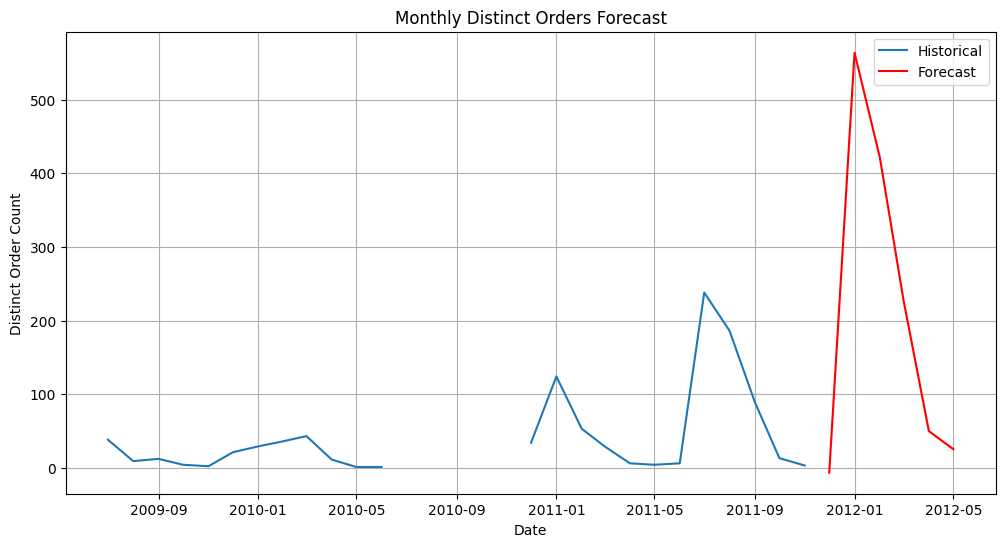

In [45]:
def prepare_monthly_time_series(df):
    # Ensure "order_date" is datetime
    if df['order_date'].dtype != 'datetime64[ns]':
        df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y', errors='coerce')
    
    # If "Year" and "Month" not in df, create them
    if 'Year' not in df.columns:
        df['Year'] = df['order_date'].dt.year
    if 'Month' not in df.columns:
        df['Month'] = df['order_date'].dt.month
    
    # Compute distinct order counts by Year-Month
    monthly_order_counts = (
        df.groupby(['Year', 'Month'])['Customer Order Code']
        .nunique()
        .reset_index(name='Distinct Order Count')
    )

    # Create Year-Month column if not present
    if 'Year-Month' not in monthly_order_counts.columns:
        monthly_order_counts['Year-Month'] = monthly_order_counts.apply(
            lambda row: f"{row['Year']}-{row['Month']:02d}", axis=1
        )
    
    # Convert "Year-Month" to datetime and set as index
    if monthly_order_counts.index.name != 'Year-Month':
        if not pd.api.types.is_datetime64_any_dtype(monthly_order_counts['Year-Month']):
            monthly_order_counts['Year-Month'] = pd.to_datetime(monthly_order_counts['Year-Month'], format='%Y-%m')
        monthly_order_counts.set_index('Year-Month', inplace=True)
    
    # Sort by index
    monthly_order_counts.sort_index(inplace=True)

    # Ensure monthly frequency
    time_series = monthly_order_counts['Distinct Order Count'].asfreq('MS')

    return time_series


def find_best_sarima_model(time_series,
                           p_values=range(0,3),
                           d_values=range(0,3),
                           q_values=range(0,3),
                           P_values=range(0,3),
                           D_values=range(0,2),
                           Q_values=range(0,3),
                           s_values=[6, 12]):  
    """
    This function does a brute-force grid search over given parameters for
    SARIMAX to find the best model based on AIC.
    
    Parameters:
    - time_series: pandas Series indexed by date
    - p_values, d_values, q_values: Ranges for the non-seasonal ARIMA parameters
    - P_values, D_values, Q_values, s_values: Ranges for seasonal ARIMA parameters and seasonal period
      For monthly data, s=12 might be common for yearly seasonality, 
      but you can try smaller or larger values.
    """
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None
    best_model = None

    warnings.filterwarnings("ignore")
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for s in s_values:
                                # Avoid models that are trivially large compared to dataset size
                                # But here we try anyway
                                try:
                                    model = sm.tsa.statespace.SARIMAX(
                                        time_series.dropna(),
                                        order=(p, d, q),
                                        seasonal_order=(P, D, Q, s),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False
                                    )
                                    results = model.fit(disp=False)
                                    if results.aic < best_aic:
                                        best_aic = results.aic
                                        best_order = (p, d, q)
                                        best_seasonal_order = (P, D, Q, s)
                                        best_model = results
                                except:
                                    continue
    return best_order, best_seasonal_order, best_aic, best_model


# Assuming df is your original DataFrame with "order_date" and "Customer Order Code"
time_series = prepare_monthly_time_series(df)

# Plot the time series
plt.figure(figsize=(12,6))
plt.plot(time_series.index, time_series.values, marker='o')
plt.title('Distinct Monthly Orders Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Distinct Order Count')
plt.grid(True)
plt.show()

# If time series is too short, reduce lags accordingly
lags = min(len(time_series.dropna())//2, 10)

sm.graphics.tsa.plot_acf(time_series.dropna(), lags=lags)
plt.show()

sm.graphics.tsa.plot_pacf(time_series.dropna(), lags=lags)
plt.show()

# Search for the best SARIMAX model
best_order, best_seasonal_order, best_aic, best_model = find_best_sarima_model(
    time_series,
    p_values=range(0,3),
    d_values=range(0,3),
    q_values=range(0,3),
    P_values=range(0,3),
    D_values=range(0,2),
    Q_values=range(0,3),
    s_values=[6, 12] # Testing a semi-annual and annual seasonality for a small dataset
)

print(f"Best SARIMA order: {best_order} Seasonal order: {best_seasonal_order} with AIC: {best_aic}")
print(best_model.summary())

# Forecast
steps_ahead = 6
forecast_res = best_model.get_forecast(steps=steps_ahead)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

print("Forecasted Distinct Orders:")
print(forecast_mean)
print("\nConfidence Intervals:")
print(forecast_ci)

# Plot the forecast
plt.figure(figsize=(12,6))
plt.plot(time_series.index, time_series.values, label='Historical')
future_index = pd.date_range(start=time_series.index[-1] + pd.offsets.MonthBegin(), periods=steps_ahead, freq='MS')
plt.plot(future_index, forecast_mean.values, label='Forecast', color='red')
plt.fill_between(future_index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color='pink', alpha=0.3)
plt.title('Monthly Distinct Orders Forecast')
plt.xlabel('Date')
plt.ylabel('Distinct Order Count')
plt.legend()
plt.grid(True)
plt.show()


# 2. Which items are demanded (Classification Model)

In [49]:
# 1. Prepare the dataset
# Ensure order_date is a datetime
if df['order_date'].dtype != 'datetime64[ns]':
    df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y', errors='coerce')

# Extract month
df['Month'] = df['order_date'].dt.month

# Define a function to map month to season (example: Northern Hemisphere)
def month_to_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(month_to_season)

# The target is "Product Code"
y = df['Product Code']

# Select features 
# Let's pick Season, Customer Country Code, and Route (NOT items)
categorical_features = ['Season', 'Customer Country Code', 'Route']

# Fill missing categorical with 'Unknown'
df[categorical_features] = df[categorical_features].fillna('Unknown')

# One-hot encode categorical variables
X = pd.get_dummies(df[categorical_features], drop_first=True)

# Remove rows with missing product codes if any
X = X[y.notna()]
y = y[y.notna()]

# 2. Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_names = list(y_test.unique())  # Replace y_test with y_train if needed

# 3. Fit a multinomial logistic regression model
from sklearn.linear_model import LogisticRegression
model_classification = LogisticRegression(random_state=0, max_iter=1000, multi_class='multinomial', solver='lbfgs')
model_classification.fit(X_train, y_train)

# 4. Make predictions
predictions = model_classification.predict(X_test)

# 5. Evaluate the model using F1-score (weighted average since multi-class)
from sklearn.metrics import f1_score, classification_report
f1 = f1_score(y_test, predictions, average='weighted')
print("F1-Score of the multinomial logistic regression model:", f1)

# Print the classification report
report = classification_report(y_test, predictions, target_names=class_names)
print("Classification Report:")
print(report)


F1-Score of the multinomial logistic regression model: 0.09717742997950822
Classification Report:
              precision    recall  f1-score   support

   L12918700       1.00      1.00      1.00         1
   L12918900       0.00      0.00      0.00         2
   L12918400       0.00      0.00      0.00         2
   L12919200       0.00      0.00      0.00         3
   L12135900       0.00      0.00      0.00         7
   L12919000       0.00      0.00      0.00         3
   L12918000       0.00      0.00      0.00         5
   L12917900       0.23      0.19      0.21        16
   L12917800       0.00      0.00      0.00         4
   L12918600       0.00      0.00      0.00        12
   L12134400       0.00      0.00      0.00         7
   L10850800       0.00      0.00      0.00         8
   L12135800       0.10      0.17      0.12         6
   L12917700       0.21      0.42      0.28        26
   L12134500       0.00      0.00      0.00        12
   L12916900       0.00      0.00    

# 3. Quantity Demanded

In [50]:
# Ensure 'order_date' is datetime if needed
if df['order_date'].dtype != 'datetime64[ns]':
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

def month_to_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(month_to_season)

# The target is 'Product Code'
y = df['Product Code']

# Features:
# We'll use 'Season', 'Customer Country Code', 'Route' (NOT items)
categorical_features = ['Season', 'Customer Country Code', 'Route']

# Fill missing categorical with 'Unknown'
df[categorical_features] = df[categorical_features].fillna('Unknown')

# One-hot encode categorical variables
X = pd.get_dummies(df[categorical_features], drop_first=True)

# Remove rows with missing product codes if any
X = X[y.notna()]
y = y[y.notna()]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a multinomial logistic regression model
model_classification = LogisticRegression(random_state=0, max_iter=1000, multi_class='multinomial', solver='lbfgs')
model_classification.fit(X_train, y_train)

# Make predictions (Product Code)
predictions = model_classification.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, predictions, average='weighted')
print("F1-Score of the multinomial logistic regression model:", f1)
report = classification_report(y_test, predictions)
print("Classification Report:")
print(report)

# ----------------------------------------
# Now handle quantity demanded (items) uncertainty
# ----------------------------------------
# Compute empirical quantiles for each Product Code from the historical data (training + historical)
quantile_levels = [0.1, 0.5, 0.9]

product_quantiles = (
    df.groupby('Product Code')['items']
      .apply(lambda x: pd.Series(mquantiles(x, prob=quantile_levels), 
                                 index=[f"q_{int(q*100)}" for q in quantile_levels]))
).unstack()

# product_quantiles now has q_10, q_50, q_90 columns for each Product Code

# Get predicted product codes
predicted_product_codes = pd.Series(predictions, index=X_test.index, name='Predicted Product Code')

# Map predicted product codes to quantiles
product_quantiles = product_quantiles.rename_axis('Product Code')
predicted_quantiles = predicted_product_codes.to_frame().merge(
    product_quantiles,
    how='left',
    left_on='Predicted Product Code',
    right_on='Product Code'
)

# Add columns for interpreted predictions
predicted_quantiles['Predicted Quantity'] = predicted_quantiles['q_50']  # median as point estimate
predicted_quantiles['Lower Bound'] = predicted_quantiles['q_10']
predicted_quantiles['Upper Bound'] = predicted_quantiles['q_90']

print(predicted_quantiles[['Predicted Product Code', 'Predicted Quantity', 'Lower Bound', 'Upper Bound']].head())

F1-Score of the multinomial logistic regression model: 0.09717742997950822
Classification Report:
              precision    recall  f1-score   support

   L10705000       1.00      1.00      1.00         1
   L10705100       0.00      0.00      0.00         2
   L10705200       0.00      0.00      0.00         2
   L10705300       0.00      0.00      0.00         3
   L10705400       0.00      0.00      0.00         7
   L10705500       0.00      0.00      0.00         3
   L10705600       0.00      0.00      0.00         5
   L10850600       0.23      0.19      0.21        16
   L10850700       0.00      0.00      0.00         4
   L10850800       0.00      0.00      0.00        12
   L10850900       0.00      0.00      0.00         7
   L10852800       0.00      0.00      0.00         8
   L10852900       0.10      0.17      0.12         6
   L12134400       0.21      0.42      0.28        26
   L12134500       0.00      0.00      0.00        12
   L12134600       0.00      0.00    

# 4. Calculate Lead Time - Quantiles Method

In [51]:
#------------------------------------------------
# 1. Data Preparation
#------------------------------------------------

# Ensure 'order_date' is datetime
if df['order_date'].dtype != 'datetime64[ns]':
    df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y', errors='coerce')

# Ensure 'requested_delivery_date' is datetime
if df['requested_delivery_date'].dtype != 'datetime64[ns]':
    df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y', errors='coerce')

# Calculate lead time in days
df['lead_time'] = (df['requested_delivery_date'] - df['order_date']).dt.days

# Extract month to determine season
df['Month'] = df['order_date'].dt.month

def month_to_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(month_to_season)

# The target is 'Product Code'
y = df['Product Code']

# Features: Season, Customer Country Code, Route (no items, no lead_time)
categorical_features = ['Season', 'Customer Country Code', 'Route']

# Fill missing categorical with 'Unknown'
df[categorical_features] = df[categorical_features].fillna('Unknown')

# One-hot encode categorical features
X = pd.get_dummies(df[categorical_features], drop_first=True)

# Remove rows with missing product codes
X = X[y.notna()]
y = y[y.notna()]

#------------------------------------------------
# 2. Classification Model
#------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_classification = LogisticRegression(random_state=0, max_iter=1000, multi_class='multinomial', solver='lbfgs')
model_classification.fit(X_train, y_train)

predictions = model_classification.predict(X_test)

f1 = f1_score(y_test, predictions, average='weighted')
print("F1-Score of the multinomial logistic regression model:", f1)
report = classification_report(y_test, predictions)
print("Classification Report:")
print(report)

#------------------------------------------------
# 3. Quantile Estimation for Items and Lead Time
#------------------------------------------------

# Define quantile levels
quantile_levels = [0.1, 0.5, 0.9]

# Compute quantiles for items by product code
product_items_quantiles = (
    df.groupby('Product Code')['items']
      .apply(lambda x: pd.Series(mquantiles(x, prob=quantile_levels), 
                                 index=[f"q_{int(q*100)}" for q in quantile_levels]))
).unstack()

product_items_quantiles = product_items_quantiles.rename_axis('Product Code')

# Compute quantiles for lead_time by product code
product_leadtime_quantiles = (
    df.groupby('Product Code')['lead_time']
      .apply(lambda x: pd.Series(mquantiles(x, prob=quantile_levels), 
                                 index=[f"q_{int(q*100)}" for q in quantile_levels]))
).unstack()

product_leadtime_quantiles = product_leadtime_quantiles.rename_axis('Product Code')

# Map predicted product codes to their quantiles
predicted_product_codes = pd.Series(predictions, index=X_test.index, name='Predicted Product Code')

# Merge for items
predicted_items_quantiles = predicted_product_codes.to_frame().merge(
    product_items_quantiles,
    how='left',
    left_on='Predicted Product Code',
    right_on='Product Code'
)

# Merge for lead time
predicted_leadtime_quantiles = predicted_product_codes.to_frame().merge(
    product_leadtime_quantiles,
    how='left',
    left_on='Predicted Product Code',
    right_on='Product Code'
)

# Add interpreted predictions:
# For items
predicted_items_quantiles['Predicted Quantity (median)'] = predicted_items_quantiles['q_50']
predicted_items_quantiles['Quantity Lower Bound'] = predicted_items_quantiles['q_10']
predicted_items_quantiles['Quantity Upper Bound'] = predicted_items_quantiles['q_90']

# For lead time
predicted_leadtime_quantiles['Predicted Lead Time (median)'] = predicted_leadtime_quantiles['q_50']
predicted_leadtime_quantiles['Lead Time Lower Bound'] = predicted_leadtime_quantiles['q_10']
predicted_leadtime_quantiles['Lead Time Upper Bound'] = predicted_leadtime_quantiles['q_90']

# Print a sample of the results
print("\nQuantile-based Predictions for Items:")
print(predicted_items_quantiles[['Predicted Product Code', 'Predicted Quantity (median)', 'Quantity Lower Bound', 'Quantity Upper Bound']].head())

print("\nQuantile-based Predictions for Lead Time:")
print(predicted_leadtime_quantiles[['Predicted Product Code', 'Predicted Lead Time (median)', 'Lead Time Lower Bound', 'Lead Time Upper Bound']].head())


F1-Score of the multinomial logistic regression model: 0.09717742997950822
Classification Report:
              precision    recall  f1-score   support

   L10705000       1.00      1.00      1.00         1
   L10705100       0.00      0.00      0.00         2
   L10705200       0.00      0.00      0.00         2
   L10705300       0.00      0.00      0.00         3
   L10705400       0.00      0.00      0.00         7
   L10705500       0.00      0.00      0.00         3
   L10705600       0.00      0.00      0.00         5
   L10850600       0.23      0.19      0.21        16
   L10850700       0.00      0.00      0.00         4
   L10850800       0.00      0.00      0.00        12
   L10850900       0.00      0.00      0.00         7
   L10852800       0.00      0.00      0.00         8
   L10852900       0.10      0.17      0.12         6
   L12134400       0.21      0.42      0.28        26
   L12134500       0.00      0.00      0.00        12
   L12134600       0.00      0.00    

In [37]:
############################################
# Step 1: Compute Historical Lead Times
############################################
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y', errors='coerce')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y', errors='coerce')

# Compute lead time in days
df['Lead Time'] = (df['requested_delivery_date'] - df['order_date']).dt.days

# Filter out non-positive lead times if they don't make sense in your context
df = df[df['Lead Time'] > 0]

############################################
# Step 2: Compute Lead Time Quantiles per Product
############################################
lead_time_quantiles = {}
quantile_levels = [0.1, 0.25, 0.5, 0.75, 0.9]

for product, group in df.groupby('Product Code'):
    product_lead_times = group['Lead Time'].values
    # Compute quantiles for lead time
    q_values = mquantiles(product_lead_times, prob=quantile_levels)
    lead_time_quantiles[product] = {
        'quantile_levels': quantile_levels,
        'quantile_values': q_values
    }

############################################
# Step 3: Simulate Lead Times for the Forecasted Products
# 
# We have final_forecast_with_quantities DataFrame with columns:
# ['Year-Month', 'Product', 'Expected_Count', 'Total_Quantity_Demanded', 'Average_Quantity_per_Order']
#
# For each product in final_forecast_with_quantities, we will simulate the lead times
# of those orders using the quantile distributions.
############################################

final_forecast_with_lead_times = []

for idx, row in final_forecast_with_quantities.iterrows():
    product = row['Product']
    expected_count = row['Expected_Count']
    month = row['Year-Month']

    if expected_count <= 0:
        # No orders expected, skip
        continue

    if product in lead_time_quantiles:
        q_data = lead_time_quantiles[product]
        q_levels = q_data['quantile_levels']
        q_values = q_data['quantile_values']

        # Simulate lead times for each expected order
        simulated_lead_times = []
        for _ in range(expected_count):
            u = np.random.rand()  # random draw from Uniform(0,1)
            # Determine which quantile bucket u falls into
            for i, ql in enumerate(q_levels):
                if u < ql:
                    simulated_lead_times.append(int(np.round(q_values[i])))
                    break
            else:
                # If u >= last quantile level, assign the highest quantile lead time
                simulated_lead_times.append(int(np.round(q_values[-1])))

        total_lead_time = sum(simulated_lead_times)
        average_lead_time = total_lead_time / expected_count

        # Add lead time info to the forecast
        record = row.to_dict()
        record['Average_Lead_Time'] = average_lead_time
        record['Total_Lead_Time'] = total_lead_time
        final_forecast_with_lead_times.append(record)
    else:
        # If no lead time quantiles for this product, fallback to mean lead time
        avg_lead = df.loc[df['Product Code'] == product, 'Lead Time'].mean()
        total_lead_time = avg_lead * expected_count

        record = row.to_dict()
        record['Average_Lead_Time'] = avg_lead
        record['Total_Lead_Time'] = total_lead_time
        final_forecast_with_lead_times.append(record)

final_forecast_with_lead_times = pd.DataFrame(final_forecast_with_lead_times)

print(final_forecast_with_lead_times)

                       Year-Month    Product  Expected_Count  \
0   1970-01-01 00:00:00.000000025  L10705000               9   
1   1970-01-01 00:00:00.000000025  L10705100               2   
2   1970-01-01 00:00:00.000000025  L10705200               1   
3   1970-01-01 00:00:00.000000025  L10705300               3   
4   1970-01-01 00:00:00.000000025  L10705400              10   
..                            ...        ...             ...   
132 1970-01-01 00:00:00.000000028  L12918600               2   
133 1970-01-01 00:00:00.000000028  L12918700               2   
134 1970-01-01 00:00:00.000000028  L12918900               1   
135 1970-01-01 00:00:00.000000028  L12919000               2   
136 1970-01-01 00:00:00.000000028  L12919200               3   

     Total_Quantity_Demanded  Average_Quantity_per_Order  Average_Lead_Time  \
0                         69                    7.666667         202.888889   
1                         20                   10.000000         230.5000

# 5. Consolidate All Models and Predict Demand, Report MAPE (Compare to 5month forecast to 2 month forecast with Monte Carlo Sims)

In [38]:
# --------------------------------------------
# Parameters
# --------------------------------------------
num_simulations = 100
quantile_levels = [0.1, 0.25, 0.5, 0.75, 0.9]

# --------------------------------------------
# Assume df is your full dataset (2009–2011)
# --------------------------------------------
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y', errors='coerce')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y', errors='coerce')

# Train on all data up to 2011-07-31 and test on last 5 months of 2011
train_df = df[(df['order_date'] >= '2009-01-01') & (df['order_date'] < '2011-08-01')].copy()
test_df = df[(df['order_date'] >= '2011-08-01') & (df['order_date'] <= '2011-12-31')].copy()

# --------------------------------------------
# Step A: Forecast Monthly Distinct Orders (Time Series)
# --------------------------------------------
train_df['Year'] = train_df['order_date'].dt.year
train_df['Month'] = train_df['order_date'].dt.month

monthly_train = (train_df.groupby(['Year','Month'])['Customer Order Code']
                 .nunique()
                 .reset_index(name='Distinct_Order_Count'))

monthly_train['Year-Month'] = pd.to_datetime(monthly_train['Year'].astype(str) + '-' +
                                            monthly_train['Month'].astype(str) + '-01')
monthly_train.set_index('Year-Month', inplace=True)
monthly_train.sort_index(inplace=True)
ts_train = monthly_train['Distinct_Order_Count'].asfreq('MS')

model = SARIMAX(ts_train.dropna(),
                order=(1,1,1),
                seasonal_order=(1,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit()

# Forecast last 5 months of 2011
steps_ahead = 5  # now we only forecast Aug-Dec 2011
forecast_res = res.get_forecast(steps=steps_ahead)
forecast_mean = forecast_res.predicted_mean

monthly_forecasts = pd.DataFrame({
    'Year-Month': forecast_mean.index,
    'Predicted_Order_Count': forecast_mean.values
}).set_index('Year-Month')

def month_to_season(m):
    if m in [12,1,2]:
        return 'Winter'
    elif m in [3,4,5]:
        return 'Spring'
    elif m in [6,7,8]:
        return 'Summer'
    else:
        return 'Autumn'

# --------------------------------------------
# Step B: Classification Model for Product Choice
# --------------------------------------------
train_df['Month'] = train_df['order_date'].dt.month
train_df['Season'] = train_df['Month'].apply(month_to_season)

categorical_features = ['Season','Customer Country Code','Curr','Route','order_type']
numeric_features = ['items','value']

train_df[categorical_features] = train_df[categorical_features].fillna('Unknown')
train_df[numeric_features] = train_df[numeric_features].fillna(0)

train_encoded = pd.get_dummies(train_df[categorical_features], drop_first=True)
X_train = pd.concat([train_df[numeric_features], train_encoded], axis=1)
y_train = train_df['Product Code']

model_classification = LogisticRegression(random_state=0, solver='lbfgs', max_iter=2000)
model_classification.fit(X_train, y_train)

product_classes = model_classification.classes_
known_feature_cols = X_train.columns

# --------------------------------------------
# Step C: Compute Quantiles for Quantity and Lead Time
# --------------------------------------------
product_quantiles = {}
for product, group in train_df.groupby('Product Code'):
    product_items = group['items'].values
    q_values = mquantiles(product_items, prob=quantile_levels)
    product_quantiles[product] = {
        'quantile_levels': quantile_levels,
        'quantile_values': q_values
    }

train_df['Lead Time'] = (train_df['requested_delivery_date'] - train_df['order_date']).dt.days
train_df = train_df[train_df['Lead Time'] > 0]
lead_time_quantiles = {}
for product, group in train_df.groupby('Product Code'):
    product_lead_times = group['Lead Time'].values
    if len(product_lead_times) > 0:
        q_values = mquantiles(product_lead_times, prob=quantile_levels)
        lead_time_quantiles[product] = {
            'quantile_levels': quantile_levels,
            'quantile_values': q_values
        }

historical_feature_distributions = {
    'Customer Country Code': train_df['Customer Country Code'].value_counts(normalize=True).to_dict(),
    'Curr': train_df['Curr'].value_counts(normalize=True).to_dict(),
    'Route': train_df['Route'].value_counts(normalize=True).to_dict(),
    'order_type': train_df['order_type'].value_counts(normalize=True).to_dict()
}

def simulate_future_orders_for_month(year_month, n_orders, distributions, known_feature_cols):
    month = year_month.month
    season = month_to_season(month)

    simulated_orders = pd.DataFrame()
    simulated_orders['Month'] = [month]*n_orders
    simulated_orders['Season'] = [season]*n_orders

    for cat_feat, dist in distributions.items():
        cats = list(dist.keys())
        probs = list(dist.values())
        simulated_orders[cat_feat] = np.random.choice(cats, size=n_orders, p=probs)

    simulated_orders['items'] = np.random.randint(1,50,size=n_orders)
    simulated_orders['value'] = np.round(np.random.uniform(10,300,n_orders),2)

    simulated_encoded = pd.get_dummies(simulated_orders, drop_first=True)
    for col in known_feature_cols:
        if col not in simulated_encoded.columns:
            simulated_encoded[col] = 0
    simulated_encoded = simulated_encoded[known_feature_cols]
    return simulated_encoded

def simulate_forecast_and_compute_mape(forecast_horizon):
    # Re-run the SARIMAX with the desired horizon
    # Actually, we have already fitted the model on the train set.
    # Just get a new forecast for 'forecast_horizon' months.
    new_forecast_res = res.get_forecast(steps=forecast_horizon)
    new_forecast_mean = new_forecast_res.predicted_mean
    new_monthly_forecasts = pd.DataFrame({
        'Year-Month': new_forecast_mean.index,
        'Predicted_Order_Count': new_forecast_mean.values
    }).set_index('Year-Month')

    final_forecast = []
    for future_month, row in new_monthly_forecasts.iterrows():
        predicted_order_count = int(round(row['Predicted_Order_Count']))
        if predicted_order_count <= 0:
            continue
        simulated_orders_for_month = simulate_future_orders_for_month(future_month, predicted_order_count,
                                                                      historical_feature_distributions, known_feature_cols)
        product_prob = model_classification.predict_proba(simulated_orders_for_month)
        expected_counts = product_prob.sum(axis=0)
        monthly_product_forecast = pd.DataFrame({
            'Year-Month': future_month,
            'Product': product_classes,
            'Expected_Count': expected_counts
        })
        final_forecast.append(monthly_product_forecast)

    if len(final_forecast) == 0:
        return None

    final_forecast = pd.concat(final_forecast, ignore_index=True)

    # Simulate quantities and lead times
    final_forecast_with_quantities = []
    for idx, row in final_forecast.iterrows():
        product = row['Product']
        month = row['Year-Month']
        expected_count = int(round(row['Expected_Count']))

        if expected_count <= 0:
            continue

        # Quantity
        if product in product_quantiles:
            q_data = product_quantiles[product]
            q_levels = q_data['quantile_levels']
            q_values = q_data['quantile_values']
            simulated_quantities = []
            for _ in range(expected_count):
                u = np.random.rand()
                for i, ql in enumerate(q_levels):
                    if u < ql:
                        simulated_quantities.append(int(np.round(q_values[i])))
                        break
                else:
                    simulated_quantities.append(int(np.round(q_values[-1])))
            total_quantity = sum(simulated_quantities)
        else:
            avg_items = train_df.loc[train_df['Product Code']==product,'items'].mean()
            total_quantity = avg_items * expected_count

        # Lead time
        if product in lead_time_quantiles:
            lt_data = lead_time_quantiles[product]
            lt_levels = lt_data['quantile_levels']
            lt_values = lt_data['quantile_values']
            simulated_lead_times = []
            for _ in range(expected_count):
                u = np.random.rand()
                for i, ql in enumerate(lt_levels):
                    if u < ql:
                        simulated_lead_times.append(int(np.round(lt_values[i])))
                        break
                else:
                    simulated_lead_times.append(int(np.round(lt_values[-1])))
            total_lead_time = sum(simulated_lead_times)
            avg_lead_time = total_lead_time / expected_count
        else:
            avg_lead = train_df.loc[train_df['Product Code']==product, 'Lead Time'].mean()
            total_lead_time = avg_lead * expected_count
            avg_lead_time = avg_lead

        final_forecast_with_quantities.append({
            'Year-Month': month,
            'Product': product,
            'Expected_Count': expected_count,
            'Total_Quantity_Demanded': total_quantity,
            'Average_Quantity_per_Order': total_quantity/expected_count if expected_count>0 else 0,
            'Average_Lead_Time': avg_lead_time,
            'Total_Lead_Time': total_lead_time
        })

    final_forecast_with_quantities = pd.DataFrame(final_forecast_with_quantities)
    if final_forecast_with_quantities.empty:
        return None

    # Compute MAPE on test data
    # Test data is last 5 months of 2011 (Aug-Dec) for the 5-month scenario
    # For the 2-month scenario, we still use the same test set (Aug-Dec) for evaluation, or
    # you could define a shorter test period. Here we keep it consistent.
    test_df['Year'] = test_df['order_date'].dt.year
    test_df['Month'] = test_df['order_date'].dt.month

    test_monthly_actual = (test_df.groupby(['Year','Month','Product Code'])['items']
                           .sum()
                           .reset_index())
    test_monthly_actual['Year-Month'] = pd.to_datetime(test_monthly_actual['Year'].astype(str)+'-'
                                                      +test_monthly_actual['Month'].astype(str)+'-01')
    test_monthly_actual.rename(columns={'Product Code':'Product','items':'Actual_Total_Quantity'}, inplace=True)

    final_forecast_with_quantities.set_index(['Year-Month','Product'], inplace=True)
    test_monthly_actual.set_index(['Year-Month','Product'], inplace=True)

    comparison_df = final_forecast_with_quantities.join(test_monthly_actual, how='inner')
    comparison_df.reset_index(inplace=True)

    comparison_df = comparison_df[comparison_df['Actual_Total_Quantity'] > 0]
    if comparison_df.empty:
        return None

    comparison_df['APE'] = np.abs((comparison_df['Actual_Total_Quantity'] - comparison_df['Total_Quantity_Demanded'])
                                  / comparison_df['Actual_Total_Quantity'])*100
    mape = comparison_df['APE'].mean()
    return mape

# Compute MAPE for the 5-month horizon scenario (no Monte Carlo, just one run)
mape_5_month = simulate_forecast_and_compute_mape(5)
print("MAPE with 5-month horizon:", mape_5_month, "%")

# Monte Carlo simulations for reducing to 2-month horizon
mapes_2_month = []
for _ in range(num_simulations):
    m = simulate_forecast_and_compute_mape(2)
    if m is not None:
        mapes_2_month.append(m)

if mapes_2_month:
    mean_mape_2 = np.mean(mapes_2_month)
    std_mape_2 = np.std(mapes_2_month)
    print(f"After reducing the horizon to 2 months and running {num_simulations} simulations:")
    print("Mean MAPE (2-month horizon):", mean_mape_2, "%")
    print("Std Dev of MAPE (2-month horizon):", std_mape_2, "%")
else:
    print("No MAPE computed for 2-month horizon simulations.")

AttributeError: 'int' object has no attribute 'month'

In [39]:
# --------------------------------------------
# Parameters
# --------------------------------------------
num_simulations = 100
quantile_levels = [0.1, 0.25, 0.5, 0.75, 0.9]

# --------------------------------------------
# Data Parsing and Splitting
# --------------------------------------------
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y', errors='coerce')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y', errors='coerce')

# Train on all data up to 2011-07-31 and test on last 5 months of 2011
train_df = df[(df['order_date'] >= '2009-01-01') & (df['order_date'] < '2011-08-01')].copy()
test_df = df[(df['order_date'] >= '2011-08-01') & (df['order_date'] <= '2011-12-31')].copy()

# --------------------------------------------
# Step A: Forecast Monthly Distinct Orders (Time Series)
# --------------------------------------------
train_df['Year'] = train_df['order_date'].dt.year
train_df['Month'] = train_df['order_date'].dt.month

monthly_train = (train_df.groupby(['Year','Month'])['Customer Order Code']
                 .nunique()
                 .reset_index(name='Distinct_Order_Count'))

monthly_train['Year-Month'] = pd.to_datetime(monthly_train['Year'].astype(str) + '-' +
                                            monthly_train['Month'].astype(str) + '-01')
monthly_train.set_index('Year-Month', inplace=True)
monthly_train.sort_index(inplace=True)
ts_train = monthly_train['Distinct_Order_Count'].asfreq('MS')

model = SARIMAX(ts_train.dropna(),
                order=(1,1,1),
                seasonal_order=(1,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit()

# Forecast last 5 months of 2011
steps_ahead = 5  # Aug-Dec 2011
forecast_res = res.get_forecast(steps=steps_ahead)
forecast_mean = forecast_res.predicted_mean

# Ensure index is DateTimeIndex (SARIMAX often returns PeriodIndex)
if isinstance(forecast_mean.index, pd.PeriodIndex):
    forecast_mean.index = forecast_mean.index.to_timestamp()

monthly_forecasts = pd.DataFrame({
    'Year-Month': forecast_mean.index,
    'Predicted_Order_Count': forecast_mean.values
}).set_index('Year-Month')

def month_to_season(m):
    if m in [12,1,2]:
        return 'Winter'
    elif m in [3,4,5]:
        return 'Spring'
    elif m in [6,7,8]:
        return 'Summer'
    else:
        return 'Autumn'

# --------------------------------------------
# Step B: Classification Model for Product Choice
# --------------------------------------------
train_df['Month'] = train_df['order_date'].dt.month
train_df['Season'] = train_df['Month'].apply(month_to_season)

categorical_features = ['Season','Customer Country Code','Curr','Route','order_type']
numeric_features = ['items','value']

train_df[categorical_features] = train_df[categorical_features].fillna('Unknown')
train_df[numeric_features] = train_df[numeric_features].fillna(0)

train_encoded = pd.get_dummies(train_df[categorical_features], drop_first=True)
X_train = pd.concat([train_df[numeric_features], train_encoded], axis=1)
y_train = train_df['Product Code']

model_classification = LogisticRegression(random_state=0, solver='lbfgs', max_iter=2000)
model_classification.fit(X_train, y_train)

product_classes = model_classification.classes_
known_feature_cols = X_train.columns

# --------------------------------------------
# Step C: Compute Quantiles for Quantity and Lead Time
# --------------------------------------------
product_quantiles = {}
for product, group in train_df.groupby('Product Code'):
    product_items = group['items'].values
    q_values = mquantiles(product_items, prob=quantile_levels)
    product_quantiles[product] = {
        'quantile_levels': quantile_levels,
        'quantile_values': q_values
    }

train_df['Lead Time'] = (train_df['requested_delivery_date'] - train_df['order_date']).dt.days
train_df = train_df[train_df['Lead Time'] > 0]
lead_time_quantiles = {}
for product, group in train_df.groupby('Product Code'):
    product_lead_times = group['Lead Time'].values
    if len(product_lead_times) > 0:
        q_values = mquantiles(product_lead_times, prob=quantile_levels)
        lead_time_quantiles[product] = {
            'quantile_levels': quantile_levels,
            'quantile_values': q_values
        }

historical_feature_distributions = {
    'Customer Country Code': train_df['Customer Country Code'].value_counts(normalize=True).to_dict(),
    'Curr': train_df['Curr'].value_counts(normalize=True).to_dict(),
    'Route': train_df['Route'].value_counts(normalize=True).to_dict(),
    'order_type': train_df['order_type'].value_counts(normalize=True).to_dict()
}

def simulate_future_orders_for_month(year_month, n_orders, distributions, known_feature_cols):
    # Ensure that year_month is a datetime-like object
    # If it's an integer, convert it or handle it appropriately.
    # For safety, we assume year_month is Timestamp. If it's not, convert:
    if isinstance(year_month, int):
        # If you know the structure, convert accordingly or raise an error
        raise ValueError(f"Expected a datetime-like object, got int: {year_month}")

    if isinstance(year_month, pd.Period):
        year_month = year_month.to_timestamp()

    if not hasattr(year_month, 'month'):
        raise ValueError(f"Expected a datetime-like object with a 'month' attribute, got: {type(year_month)}")

    month = year_month.month
    season = month_to_season(month)

    simulated_orders = pd.DataFrame()
    simulated_orders['Month'] = [month]*n_orders
    simulated_orders['Season'] = [season]*n_orders

    for cat_feat, dist in distributions.items():
        cats = list(dist.keys())
        probs = list(dist.values())
        simulated_orders[cat_feat] = np.random.choice(cats, size=n_orders, p=probs)

    simulated_orders['items'] = np.random.randint(1,50,size=n_orders)
    simulated_orders['value'] = np.round(np.random.uniform(10,300,n_orders),2)

    simulated_encoded = pd.get_dummies(simulated_orders, drop_first=True)
    for col in known_feature_cols:
        if col not in simulated_encoded.columns:
            simulated_encoded[col] = 0
    simulated_encoded = simulated_encoded[known_feature_cols]
    return simulated_encoded

def simulate_forecast_and_compute_mape(forecast_horizon):
    # Get a new forecast for the specified horizon
    new_forecast_res = res.get_forecast(steps=forecast_horizon)
    new_forecast_mean = new_forecast_res.predicted_mean
    
    # Ensure we have a DatetimeIndex
    if isinstance(new_forecast_mean.index, pd.PeriodIndex):
        new_forecast_mean.index = new_forecast_mean.index.to_timestamp()

    new_monthly_forecasts = pd.DataFrame({
        'Year-Month': new_forecast_mean.index,
        'Predicted_Order_Count': new_forecast_mean.values
    }).set_index('Year-Month')

    final_forecast = []
    for future_month, row in new_monthly_forecasts.iterrows():
        predicted_order_count = int(round(row['Predicted_Order_Count']))
        if predicted_order_count <= 0:
            continue
        simulated_orders_for_month = simulate_future_orders_for_month(
            future_month, predicted_order_count, historical_feature_distributions, known_feature_cols
        )
        product_prob = model_classification.predict_proba(simulated_orders_for_month)
        expected_counts = product_prob.sum(axis=0)
        monthly_product_forecast = pd.DataFrame({
            'Year-Month': future_month,
            'Product': product_classes,
            'Expected_Count': expected_counts
        })
        final_forecast.append(monthly_product_forecast)

    if len(final_forecast) == 0:
        return None

    final_forecast = pd.concat(final_forecast, ignore_index=True)

    # Simulate quantities and lead times
    final_forecast_with_quantities = []
    for idx, row in final_forecast.iterrows():
        product = row['Product']
        month = row['Year-Month']
        expected_count = int(round(row['Expected_Count']))

        if expected_count <= 0:
            continue

        # Quantity simulation
        if product in product_quantiles:
            q_data = product_quantiles[product]
            q_levels = q_data['quantile_levels']
            q_values = q_data['quantile_values']
            simulated_quantities = []
            for _ in range(expected_count):
                u = np.random.rand()
                for i, ql in enumerate(q_levels):
                    if u < ql:
                        simulated_quantities.append(int(np.round(q_values[i])))
                        break
                else:
                    simulated_quantities.append(int(np.round(q_values[-1])))
            total_quantity = sum(simulated_quantities)
        else:
            avg_items = train_df.loc[train_df['Product Code']==product,'items'].mean()
            total_quantity = avg_items * expected_count

        # Lead time simulation
        if product in lead_time_quantiles:
            lt_data = lead_time_quantiles[product]
            lt_levels = lt_data['quantile_levels']
            lt_values = lt_data['quantile_values']
            simulated_lead_times = []
            for _ in range(expected_count):
                u = np.random.rand()
                for i, ql in enumerate(lt_levels):
                    if u < ql:
                        simulated_lead_times.append(int(np.round(lt_values[i])))
                        break
                else:
                    simulated_lead_times.append(int(np.round(lt_values[-1])))
            total_lead_time = sum(simulated_lead_times)
            avg_lead_time = total_lead_time / expected_count
        else:
            avg_lead = train_df.loc[train_df['Product Code']==product, 'Lead Time'].mean()
            total_lead_time = avg_lead * expected_count
            avg_lead_time = avg_lead

        final_forecast_with_quantities.append({
            'Year-Month': month,
            'Product': product,
            'Expected_Count': expected_count,
            'Total_Quantity_Demanded': total_quantity,
            'Average_Quantity_per_Order': total_quantity/expected_count if expected_count>0 else 0,
            'Average_Lead_Time': avg_lead_time,
            'Total_Lead_Time': total_lead_time
        })

    final_forecast_with_quantities = pd.DataFrame(final_forecast_with_quantities)
    if final_forecast_with_quantities.empty:
        return None

    # Compute MAPE on test data
    test_df['Year'] = test_df['order_date'].dt.year
    test_df['Month'] = test_df['order_date'].dt.month

    test_monthly_actual = (test_df.groupby(['Year','Month','Product Code'])['items']
                           .sum()
                           .reset_index())
    test_monthly_actual['Year-Month'] = pd.to_datetime(test_monthly_actual['Year'].astype(str)+'-'
                                                      +test_monthly_actual['Month'].astype(str)+'-01')
    test_monthly_actual.rename(columns={'Product Code':'Product','items':'Actual_Total_Quantity'}, inplace=True)

    final_forecast_with_quantities.set_index(['Year-Month','Product'], inplace=True)
    test_monthly_actual.set_index(['Year-Month','Product'], inplace=True)

    comparison_df = final_forecast_with_quantities.join(test_monthly_actual, how='inner')
    comparison_df.reset_index(inplace=True)

    comparison_df = comparison_df[comparison_df['Actual_Total_Quantity'] > 0]
    if comparison_df.empty:
        return None

    comparison_df['APE'] = np.abs((comparison_df['Actual_Total_Quantity'] - comparison_df['Total_Quantity_Demanded'])
                                  / comparison_df['Actual_Total_Quantity'])*100
    mape = comparison_df['APE'].mean()
    return mape

# Compute MAPE for the 5-month horizon scenario
mape_5_month = simulate_forecast_and_compute_mape(5)
print("MAPE with 5-month horizon:", mape_5_month, "%")

# Monte Carlo simulations for reducing to 2-month horizon
mapes_2_month = []
for _ in range(num_simulations):
    m = simulate_forecast_and_compute_mape(2)
    if m is not None:
        mapes_2_month.append(m)

if mapes_2_month:
    mean_mape_2 = np.mean(mapes_2_month)
    std_mape_2 = np.std(mapes_2_month)
    print(f"After reducing the horizon to 2 months and running {num_simulations} simulations:")
    print("Mean MAPE (2-month horizon):", mean_mape_2, "%")
    print("Std Dev of MAPE (2-month horizon):", std_mape_2, "%")
else:
    print("No MAPE computed for 2-month horizon simulations.")

ValueError: Expected a datetime-like object, got int: 20